<center>
    <h1>Tarea 3 ANN</h1>
    <h2>Recurrent Neural Networks</h2>
    <br>
    <h3>Diego Pérez - 201173045-3</h3>
    <h3>Ariel Sanhueza - 201173005-4</h3>
</center>

### Importación de módulos a utilizar durante los experimentos.

In [13]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, GRU
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline

### RNN en series de tiempo

Se utilizará el dataset International Airline Passengers y el objetivo de la red a entrenar será predecir el número de pasajeros en vuelos internacionales.

#### a) Cargar, dividir y escalar el dataset

Se utilizará el MinMaxScaler en el rango (0,1), es decir, se tomará el menor y mayor valor del dataset y se asignarán como 0 y 1 respectivamente. Todos los demas valores del dataset se escalarán apropiadamente en base al máximo y mínimo.

In [33]:
### LOAD THE DATASET
url = 'http://www.inf.utfsm.cl/~cvalle/international-airline-passengers.csv'
dataframe = pd.read_csv(url, sep=',', usecols=[1], engine='python', skipfooter=3)
dataframe[:] = dataframe[:].astype('float32')

In [34]:
### SPLIT INTO TRAINING AND TEST SETS
df_train, df_test = dataframe[0:96].values, dataframe[96:].values
### SCALE BOTH SETS USING THE SAME MINMAXSCALER
scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

Con los datos ya divididos y escalados, es necesario construir la matriz de entrada para las RNN, a partir de la serie de tiempo.

#### b) Transformar entrada

La siguiente función transforma un vector de entrada (serie de tiempo) considerando un lag como parámentro, para poder ser utilizado como input de las RNN.

In [49]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### c) Crear datsets

Usando lag igual a 3, se crean los dataset de entrenamiento y pruebas.

In [50]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
print('Conjunto de entrenamiento con lag=' + str(lag) + ': ', trainX.shape)
print('Conjunto de pruebas con lag=' + str(lag) + ': ', testX.shape)

Conjunto de entrenamiento con lag=3:  (93, 3)
Conjunto de pruebas con lag=3:  (45, 3)


#### d) Transformación para LSTM

Para poder usar el dataset en una LSTM, necesitamos entradas de la forma [samples, time steps, features].

In [37]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print('Conjunto de entrenamiento con lag=' + str(lag) + ': ', trainX.shape)
print('Conjunto de pruebas con lag=' + str(lag) + ': ', testX.shape)

Conjunto de entrenamiento con lag=3:  (92, 1, 3)
Conjunto de pruebas con lag=3:  (44, 1, 3)


#### e) Entrenamiento

Con las entradas en el formato correcto, generamos el modelo de la red, para luego entrenarla.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 4)             128         lstm_input_1[0][0]               
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             5           lstm_1[0][0]                     
Total params: 133
____________________________________________________________________________________________________


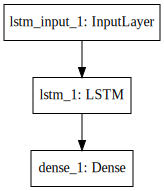

In [7]:
model = Sequential()
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

La inicialización de los pesos es por Gaussiana escalada, como se propone en Glorot, 2010. Para los pesos internos, se usa inicialización ortogonal, donde la matriz obtenida tiene eigenvalues igual a 1, atenuando el problema de vanishing gradient.
Los parámetros por defecto del optimizador Adam son:
* learning rate = 0.001
* beta_1 = 0.9
* beta_2 = 0.999

In [ ]:
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)
model.save('RNN-lag3.h5')

#### f) Predicción y desnormalización.

Se realiza la predicción para los conjuntos de entrenamiento y pruebas, desnormalizando los datos para obtener el error en la escala original.

In [7]:
# LOAD MODEL
model = load_model('RNN-lag3.h5')
# PREDICT SETS
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [18]:
def rmse(y_true, y_pred):
    scaled_pred = scaler.inverse_transform(y_pred)
    scaled_true = scaler.inverse_transform(y_true)
    return np.sqrt(mean_squared_error(scaled_true, scaled_pred[:,0]))

#### g) RMSE

In [9]:
# CALCULATE ROOT MSE
trainScore = rmse(trainY.reshape(-1,1), trainPredict.reshape(-1,1))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = rmse(testY.reshape(-1,1), testPredict.reshape(-1,1))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 20.42 RMSE
Test Score: 62.23 RMSE


El resultado es el esperado, con un mayor error en el conjunto de prueba, que corresponde a t posteriores al conjunto de entrenamiento.

#### h) Graficar

In [53]:
def plot_predict(original, train_pred, test_pred, scaler, lag=1):
    trainPredict = scaler.inverse_transform(train_pred)
    testPredict = scaler.inverse_transform(test_pred)
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(original)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(original)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(lag*2):len(original), :] = testPredict

    import matplotlib.pyplot as plt

    # plot baseline and predictions
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(original)
    ax.plot(trainPredictPlot)
    ax.plot(testPredictPlot)

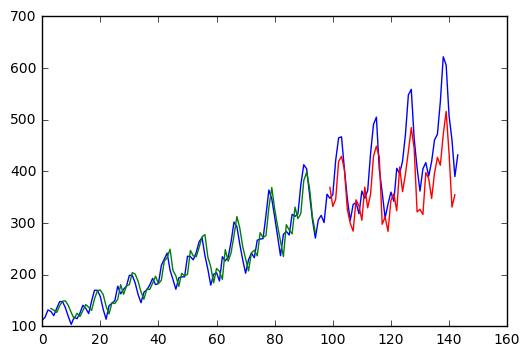

In [11]:
plot_predict(dataframe.values, trainPredict, testPredict, scaler, lag)

Los gráficos corresponden a los errores encontrados anteriormente. Se puede apreciar en el conjunto de prueba que a mayor t, mayor es el error de la predicción, ya que pasado t=95, se está extrapolando.

#### h) Determinar bloques con 5-fold CV

Se utilizará GridSearch de sklearn, que permite encontrar los hyperparámetros óptimos usando cross validation. Keras provee una API para utilizar sus modelos como estimadores en sklearn. El código es el siguiente.

In [54]:
def create_model(nb=4):
    model = Sequential()
    model.add(LSTM(nb, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

seed = 7
np.random.seed(seed)

model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = dict(nb=[4,6,8,10,12], nb_epoch=[100], batch_size=[1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_result = grid.fit(trainX, trainY)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


MSE LSTM NB=4 : 0.00586441389052
MSE LSTM NB=6 : 0.00656935837371
MSE LSTM NB=8 : 0.00675000006019
MSE LSTM NB=10 : 0.00532124102383
MSE LSTM NB=12 : 0.00723281054501


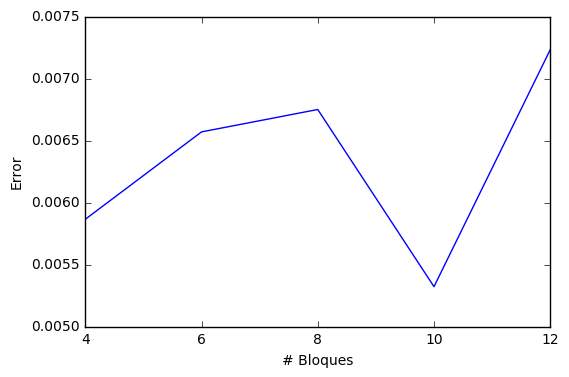

In [67]:
nb=np.array([4,6,8,10,12])
for i in range(0,5):
    print('MSE LSTM NB=' + str(nb[i]) + ' :', grid_result.cv_results_['mean_test_score'][i])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('# Bloques')
ax.set_ylabel('Error')
ax.set_xticks(np.array([0,1,2,3,4]))
ax.set_xticklabels(nb.astype('str'))

ax.plot(np.arange(0, nb.size),grid_result.cv_results_['mean_test_score'])


El mejor resultado se obtuvo con 10 bloques. Los errores se calcularon sobre el conjunto escalado, por lo que no son comparables con errores anteriores, pero si entre ellos. Usando 4 bloques se obtiene un error similar y disminuye la complejidad del modelo, por lo que se usará para comparar resultados en las siguientes secciones.

#### i) Comparación variando el lag

In [8]:
lag_scores = np.array([])
for i in range(1,5):
    model = load_model('RNN-lag' + str(i) + '.h5')
    x, y_true = create_dataset(stream_test_scaled, i)
    x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
    y_pred = model.predict(x)
    lag_scores = np.append(lag_scores, rmse(y_true, y_pred))
    print('RMSE LSTM lag=' + str(i) + ': ', lag_scores[-1])

RMSE LSTM lag=1:  63.8134346008
RMSE LSTM lag=2:  56.1345443726
RMSE LSTM lag=3:  64.1059570312
RMSE LSTM lag=4:  71.6499328613


El mejor resutado se obtuvo con lag igual a 2.

#### j) Comparación con GRU y SimpleRNN

#### SimpleRNN

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
simplernn_1 (SimpleRNN)          (None, 4)             32          simplernn_input_2[0][0]          
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             5           simplernn_1[0][0]                
Total params: 37
____________________________________________________________________________________________________


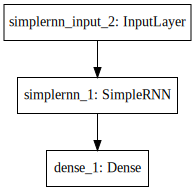

In [15]:
model = Sequential()
model.add(SimpleRNN(4, input_dim=lag, inner_init='orthogonal', activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))


#### Resultados

RMSE SimpleRNN:  74.3907


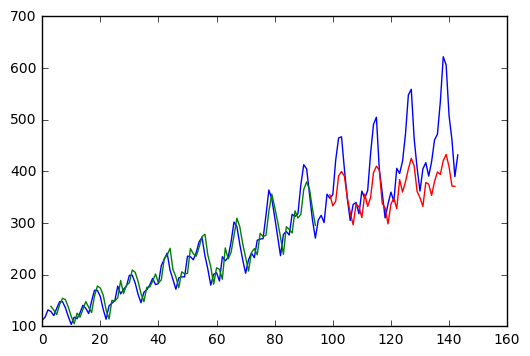

In [25]:
model = load_model('RNN-simple.h5')
simpleTrainPredict = model.predict(trainX)
simpleTestPredict = model.predict(testX)
simple_score = rmse(testY.reshape(-1,1), simpleTestPredict.reshape(-1,1))
print('RMSE SimpleRNN: ', simple_score)
plot_predict(dataframe.values, simpleTrainPredict, simpleTestPredict, scaler, lag)

#### GRU

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
gru_1 (GRU)                      (None, 4)             96          gru_input_2[0][0]                
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             5           gru_1[0][0]                      
Total params: 101
____________________________________________________________________________________________________


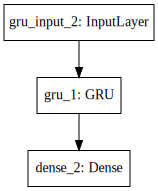

In [26]:
model = Sequential()
model.add(GRU(4, input_dim=lag, inner_init='orthogonal',activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### Resultados

RMSE GRU:  52.5542


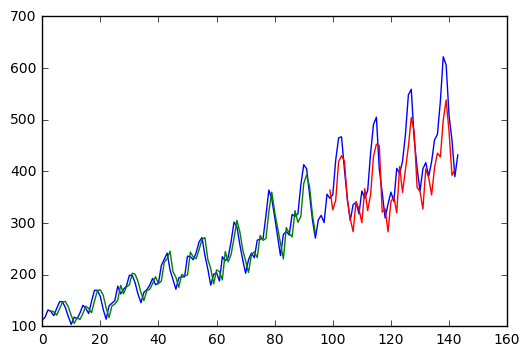

In [28]:
model = load_model('RNN-gru.h5')
gruTrainPredict = model.predict(trainX)
gruTestPredict = model.predict(testX)
gru_score = rmse(testY.reshape(-1,1), gruTestPredict.reshape(-1,1))
print('RMSE GRU: ', gru_score)
plot_predict(dataframe.values, gruTrainPredict, gruTestPredict, scaler, lag)

Se observa una mejor extrapolación usando GRU, y con un tiempo de entrenamiento menor. Su rendimiento es similar a LSTM pero al tener una complejidad menor, es más eficiente.

#### k) Cambio en la dimensión de entrada

En vez de entrenar la LSTM con muestras de 1 timestep con 3 características, se hará con muestras de 3 timesteps y 1 característica, que describe de mejor forma el problema.

In [51]:
trainX_ts3 = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX_ts3 = testX.reshape(testX.shape[0], testX.shape[1], 1)

#### Resultados

RMSE LSTM ts=3:  58.3046


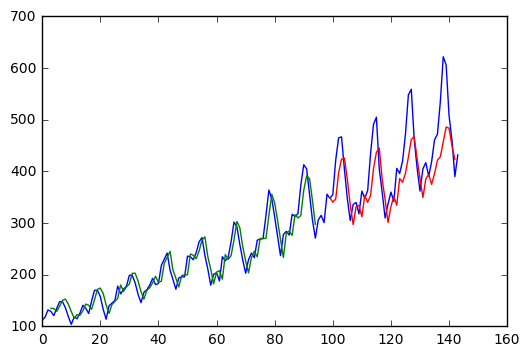

In [41]:
model = load_model('RNN-lag3-ts3.h5')
ts3TrainPredict = model.predict(trainX_ts3)
ts3TestPredict = model.predict(testX_ts3)
ts3_score = rmse(testY.reshape(-1,1), ts3TestPredict.reshape(-1,1))
print('RMSE LSTM ts=3: ', ts3_score)
plot_predict(dataframe.values, ts3TrainPredict, ts3TestPredict, scaler, lag)

Se observa una leve mejora con respecto a la LSTM anterior, y computacionalmente no se observó una diferencia significativa, posiblemente por lo simple del modelo y la baja precisión con que se mide el tiempo transcurrido por epoch. En los siguientes experimentos se usará ésta representación de los datos.

#### l) LSTM con memoria entre batches de tamaño 1

Se experimentará memoria entre batches, es decir, usar los estados al finalizar un batch como estados iniciales del siguiente batch. Entre cada epoch se resetean los estados.

In [ ]:
batch_size = 1

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

for i in range(100):
	model.fit(trainX_ts3, trainY_ts3, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
model.save('RNN-lag3-mbb1.h5')

#### Resultados

RMSE LSTM MBB=1:  51.965


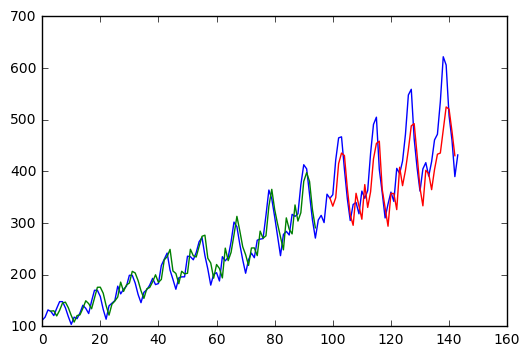

In [45]:
model = load_model('RNN-lag3-mbb1.h5')
mbb1TrainPredict = model.predict(trainX_ts3, batch_size=1)
model.reset_states()
mbb1TestPredict = model.predict(testX_ts3, batch_size=1)
mbb1_score = rmse(testY.reshape(-1,1), mbb1TestPredict.reshape(-1,1))
print('RMSE LSTM MBB=1: ', mbb1_score)
plot_predict(dataframe.values, mbb1TrainPredict, mbb1TestPredict, scaler, lag)

Este es el mejor resultado obtenido hasta el momento, superando a GRU. Con un mayor control sobre los estados de la red, específicamente, el momento en que se reinician, es posible aumentar el rendimiento de la red.

#### m) LSTM con memoria entre batches de tamaño 3

In [ ]:
batch_size = 3

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

for i in range(100):
    model.fit(trainX_ts3, trainY_ts3, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
model.save('RNN-lag3-mbb3.h5')

#### Resultados

RMSE LSTM MBB=3:  85.3468


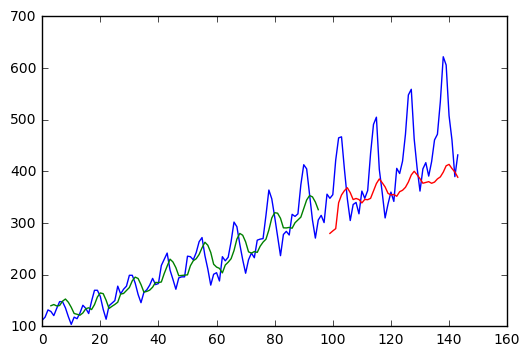

In [54]:
model = load_model('RNN-lag3-mbb3.h5')
mbb3TrainPredict = model.predict(trainX_ts3, batch_size=3)
model.reset_states()
mbb3TestPredict = model.predict(testX_ts3, batch_size=3)
mbb3_score = rmse(testY.reshape(-1,1), mbb3TestPredict.reshape(-1,1))
print('RMSE LSTM MBB=3: ', mbb3_score)
plot_predict(dataframe.values, mbb3TrainPredict, mbb3TestPredict, scaler, lag)

El resultado es el peor hasta el momento. Se puede argumentar que el tamaño del batch no es el indicado para esta secuencia en particular, pero probablemente se debe a la cantidad de bloques de la LSTM, y del tiempo de entrenamiento. Con un modelo mas robusto y mas entrenamiento posiblemente se obtengan buenos resultados.

#### n) LSTM apilada con memoria entre batches

Al igual que las redes Feed Forward, las RNN se pueden apilar, con el propósito de modelar relaciones más complejas. El método a utilizar es el más directo (y el único implementado en Keras), donde se conectan inputs con outputs, pero pueden apilarse de otras formas.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (1, 3, 4)             96          lstm_input_13[0][0]              
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (1, 4)                144         lstm_1[0][0]                     
____________________________________________________________________________________________________
dense_3 (Dense)                  (1, 1)                5           lstm_2[0][0]                     
Total params: 245
____________________________________________________________________________________________________


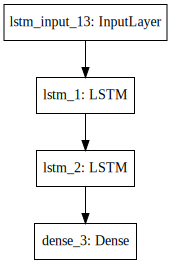

In [55]:
batch_size = 1

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

for i in range(100):
	model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
model.save('RNN-lag3-stacked1.h5')

#### Resultados

RMSE LSTM STACKED:  59.1396


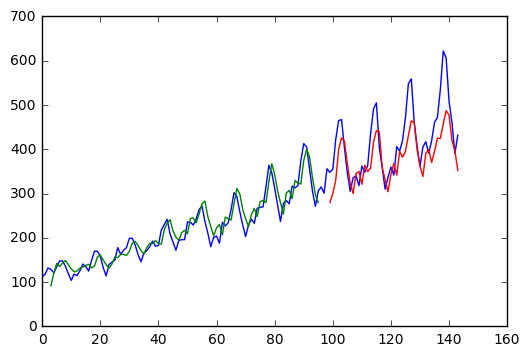

In [57]:
model = load_model('RNN-lag3-stacked1.h5')
stackedTrainPredict = model.predict(trainX_ts3, batch_size=1)
model.reset_states()
stackedTestPredict = model.predict(testX_ts3, batch_size=1)
stacked_score = rmse(testY.reshape(-1,1), stackedTestPredict.reshape(-1,1))
print('RMSE LSTM STACKED: ', stacked_score)
plot_predict(dataframe.values, stackedTrainPredict, stackedTestPredict, scaler, lag)

El resultado es mejor que el de la LSTM simple, pero GRU y LSTM con memoria entre batches de tamaño 1 son considerablemente mejores. Es posible que con mayor entrenamiento se logren mejores resultados.